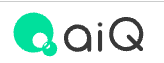

[disclaimer](./disclaimer.txt/)

# Data Handler

データベースからデータを取得し、保持するためのコンポネントです。<br>
保持しているデータを加工して新しい feature を作成したり、グラフに可視化させる機能を持ちます。

## 0. 事前準備

In [1]:
# サンプル用のライブラリをインポート
import os
import pandas as pd

### データハンドラー(DAL)のインポート

In [2]:
from aiq_strategy_robot.data.data_accessor import DAL
sdh = DAL()

### ヘルパー関数のインポート

データソース（**factset**, **finnhub**..etc）からデータロードを行う際に、ハンドラーのヘルパー関数を使用します.<br>
以下に当サンプルで利用するヘルパー関数をインポートします.

In [3]:
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_symbol_lookup,
    load_finnhub_fundamental, 
    load_finnhub_equity_data, 
)

from aiq_strategy_robot.data.ALTERNATIVE import (
    load_alternative_aiq_pos_csmr_goods_universe, 
    load_alternative_aiq_pos_csmr_goods_data
)

## 1. symbol_lookup

一般的な Bloomberg で使う Ticker コードからそれぞれのデータベンダーの symbol コードを調べるために使う end pointです

In [4]:
# 例： finnhub loader の symbol_lookup
tickers = ['4661 JP', '9983 JP', 'AAPL US']

df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=['4661 JP', '9983 JP', 'AAPL US']).retrieve()
display(df_symbols_finnhub.head())

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,ticker
0,JPY,ORIENTAL LAND CO LTD,4661.T,BBG000HPZ220,None,XJPX,BBG001S9BPK7,4661.T,,Common Stock,4661 JP
1,JPY,FAST RETAILING CO LTD,9983.T,BBG000CLY9R3,None,XJPX,BBG001S82FV9,9983.T,,Common Stock,9983 JP
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL.T,NaN,NaN,AAPL US


### オルタナティブデータとFinnhubの両方に存在するSymbolを取得

#### オルタナティブデータ`aiQ POS csmr goods`のuniverseを取得

In [5]:
sdh = DAL()
aiq_pos_universe = load_alternative_aiq_pos_csmr_goods_universe(sdh).retrieve()
aiq_pos_universe.head()

,FIGI,TICKER
0,BBG000BXKF62,2229
2,BBG000BN8V90,2733
3,BBG000BW46C5,2224
4,BBG00P84G2L2,4931
5,BBG000DK33K8,4956


#### Finnhubのシンボルを取得
`aiQ POS csmr goods`のuniverseのTickerをキーに、Finnhubのシンボルを取得

In [6]:
# シンボルの取得
df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=(aiq_pos_universe.TICKER + ' JP').to_list() ).retrieve()

サンプルとして6件抽出

In [7]:
num = 6
df_symbols_finnhub = df_symbols_finnhub.dropna(subset='currency').sample(num)
display(df_symbols_finnhub)

tickers = df_symbols_finnhub.ticker.to_list()
alt_tickers = df_symbols_finnhub.ticker.str.split(' ').str[0].to_list()
finnhub_symbols = df_symbols_finnhub.symbol.to_list()

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,ticker
53,JPY,ASAHI GROUP HOLDINGS LTD,2502.T,BBG000BFVYN9,None,XJPX,BBG001S6B625,2502.T,,Common Stock,2502 JP
93,JPY,TOYO SUISAN KAISHA LTD,2875.T,BBG000BCV808,None,XJPX,BBG001S6C884,2875.T,,Common Stock,2875 JP
129,JPY,OHKI HEALTHCARE HOLDINGS,3417.T,BBG009XY5272,None,XJPX,BBG009XY5254,3417.T,,Common Stock,3417 JP
151,JPY,NICCA CHEMICAL CO LTD,4463.T,BBG000BJ1C25,None,XJPX,BBG001S7DXL1,4463.T,,Common Stock,4463 JP
0,JPY,KYOKUYO CO LTD,1301.T,BBG000BH57B6,None,XJPX,BBG001S6C0Y2,1301.T,,Common Stock,1301 JP
74,JPY,S ISHIMITSU & CO LTD,2750.T,BBG000MSXSJ5,None,XJPX,BBG001SKHLD3,2750.T,,Common Stock,2750 JP


## 2. 株価の取得

In [9]:
sdh = DAL()

# 日次データの取得
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='D',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

2750.T: loading...: 100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


close    high     low    open   volume  dividends  \
ticker  datetime                                                         
2502 JP 2010-01-04  1732.0  1747.0  1732.0  1740.0   904800        0.0   
        2010-01-05  1751.0  1755.0  1733.0  1740.0  2093100        0.0   
        2010-01-06  1756.0  1765.0  1743.0  1755.0  1389400        0.0   
        2010-01-07  1750.0  1760.0  1745.0  1757.0   989800        0.0   
        2010-01-08  1751.0  1764.0  1739.0  1750.0  2736500        0.0   

                    split_ratio  
ticker  datetime                 
2502 JP 2010-01-04          1.0  
        2010-01-05          1.0  
        2010-01-06          1.0  
        2010-01-07          1.0  
        2010-01-08          1.0

In [10]:
# 週次データを取得
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='W',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

2750.T: loading...: 100%|██████████| 6/6 [00:22<00:00,  3.72s/it]


close    high     low    open      volume  dividends  \
ticker  datetime                                                            
2502 JP 2010-01-04  1751.0  1765.0  1732.0  1740.0   8113600.0        0.0   
        2010-01-12  1786.0  1789.0  1745.0  1759.0   7571700.0        0.0   
        2010-01-18  1732.0  1794.0  1720.0  1763.0   8702900.0        0.0   
        2010-01-25  1755.0  1775.0  1694.0  1730.0  10968500.0        0.0   
        2010-02-01  1751.0  1830.0  1750.0  1755.0  14457200.0        0.0   

                    split_ratio  
ticker  datetime                 
2502 JP 2010-01-04          1.0  
        2010-01-12          1.0  
        2010-01-18          1.0  
        2010-01-25          1.0  
        2010-02-01          1.0

### Appendix

#### ロードデータの確認

取得データはハンドラーに登録され、取得データ毎に`data_id`が付与されます.

In [11]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,None,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,NaN,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00


In [12]:
# Aliasを設定
sdh.set_alias({1: 'finhub_price_D', 2: 'finhub_price_W'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00


#### ロードデータの取得
#### 1. ロード直後のハンドラーから`retrieve`メソッドで取得
`retrieve`メソッドでは直前にロードしたデータのみ取得できます.

In [13]:
sdh.retrieve().tail()

close   high    low   open   volume  dividends  \
ticker  datetime                                                     
2750 JP 2023-11-27  749.0  750.0  737.0  742.0  18200.0        0.0   
        2023-12-04  781.0  796.0  749.0  752.0  69400.0        0.0   
        2023-12-11  752.0  790.0  752.0  790.0  26400.0        0.0   
        2023-12-18  765.0  766.0  741.0  752.0  26100.0        0.0   
        2023-12-25  758.0  765.0  746.0  762.0  20200.0        0.0   

                    split_ratio  
ticker  datetime                 
2750 JP 2023-11-27          1.0  
        2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0

#### 2. `data_id`を指定して`get_raw_data`メソッドで取得
`data_id`により登録済みのデータを取得できます.

In [14]:
sdh.get_raw_data(2).tail()

close   high    low   open    volume  dividends  \
ticker  datetime                                                      
4463 JP 2023-12-04  929.0  986.0  928.0  986.0  110100.0        0.0   
        2023-12-11  933.0  948.0  929.0  940.0   98900.0        0.0   
        2023-12-18  937.0  941.0  920.0  930.0   55000.0        0.0   
        2023-12-25  929.0  970.0  929.0  934.0  181500.0        0.0   
        2023-12-28    NaN    NaN    NaN    NaN       NaN       16.0   

                    split_ratio  
ticker  datetime                 
4463 JP 2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0  
        2023-12-28          1.0

## 3. 財務データの取得

In [15]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='ic',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

2750.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


costOfGoodsSold  dilutedAverageSharesOutstanding  \
ticker  datetime                                                       
2502 JP 2014-06-30         257495.0                            488.0   
        2014-09-30         286005.0                            465.0   
        2014-12-31         301972.0                            463.0   
        2015-03-31         226944.0                            463.0   
        2015-06-30         282871.0                            461.0   

                    dilutedEPS     ebit  grossIncome  interestIncomeExpense  \
ticker  datetime                                                              
2502 JP 2014-06-30       34.33  28303.0     178725.0                 4474.0   
        2014-09-30       75.36  44440.0     197772.0                 -261.0   
        2014-12-31       31.78  40194.0     188460.0                 4228.0   
        2015-03-31       28.78  10806.0     147248.0                 2513.0   
        2015-06-30       56.73  36477.0     199761.0                 3446.0   

                    minorityInterest  netIncome  netIncomeAfterTaxes  \
ticker  datetime                                                       
2502 JP 2014-06-30              65.0    16751.0              16686.0   
        2014-09-30            -155.0    35045.0              35200.0   
        2014-12-31              96.0    14713.0              14617.0   
        2015-03-31             404.0    13327.0              12923.0   
        2015-06-30             113.0    26157.0              26044.0   

                    otherOperatingExpensesTotal  pretaxIncome  \
ticker  datetime                                                
2502 JP 2014-06-30                          NaN       28915.0   
        2014-09-30                          0.0       61618.0   
        2014-12-31                          0.0       30266.0   
        2015-03-31                          1.0       13600.0   
        2015-06-30                         -1.0       38359.0   

                    provisionforIncomeTaxes   revenue  sgaExpense  \
ticker  datetime                                                    
2502 JP 2014-06-30                  12229.0  436220.0    150422.0   
        2014-09-30                  26418.0  483777.0    153332.0   
        2014-12-31                  15649.0  490432.0    148266.0   
        2015-03-31                    677.0  374192.0    136441.0   
        2015-06-30                  12315.0  482632.0    163285.0   

                    totalOperatingExpense  nonRecurringItems  \
ticker  datetime                                               
2502 JP 2014-06-30               150422.0            -2003.0   
        2014-09-30               153332.0            -1805.0   
        2014-12-31               148266.0           -11791.0   
        2015-03-31               136442.0              974.0   
        2015-06-30               163284.0              124.0   

                    totalOtherIncomeExpenseNet  gainLossOnDispositionOfAssets  
ticker  datetime                                                               
2502 JP 2014-06-30                     -1042.0                         -817.0  
        2014-09-30                      5498.0                        13746.0  
        2014-12-31                     -2251.0                         -114.0  
        2015-03-31                      -276.0                         -417.0  
        2015-06-30                      -629.0                        -1059.0

In [16]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='bs',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

2750.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


accountsPayable  accountsReceivables  \
ticker  datetime                                           
2502 JP 2014-06-30         107244.0             290926.0   
        2014-09-30         109349.0             274942.0   
        2014-12-31         130402.0             348175.0   
        2015-03-31         101421.0             260320.0   
        2015-06-30         112267.0             309592.0   

                    additionalPaidInCapital  cashEquivalents  \
ticker  datetime                                               
2502 JP 2014-06-30                 154519.0          46676.0   
        2014-09-30                 143368.0          45010.0   
        2014-12-31                 143339.0          65064.0   
        2015-03-31                 120568.0          74079.0   
        2015-06-30                 120540.0          56150.0   

                    cashShortTermInvestments  commonStock  currentAssets  \
ticker  datetime                                                           
2502 JP 2014-06-30                   46676.0     182531.0       550004.0   
        2014-09-30                   45010.0     182531.0       528597.0   
        2014-12-31                   65064.0     182531.0       603842.0   
        2015-03-31                   74079.0     182531.0       541241.0   
        2015-06-30                   56150.0     182531.0       577662.0   

                    currentLiabilities  currentPortionLongTermDebt  \
ticker  datetime                                                     
2502 JP 2014-06-30            741879.0                     58431.0   
        2014-09-30            708251.0                     20000.0   
        2014-12-31            757374.0                     20000.0   
        2015-03-31            713606.0                     20000.0   
        2015-06-30            706317.0                         NaN   

                    deferredIncomeTax  ...  totalEquity  totalLiabilities  \
ticker  datetime                       ...                                  
2502 JP 2014-06-30            37840.0  ...     863631.0          990569.0   
        2014-09-30            38276.0  ...     839995.0          996032.0   
        2014-12-31            48611.0  ...     881091.0         1055518.0   
        2015-03-31            53217.0  ...     858056.0         1017560.0   
        2015-06-30            54265.0  ...     871751.0         1046830.0   

                    totalReceivables  treasuryStock  \
ticker  datetime                                      
2502 JP 2014-06-30          290926.0       -19082.0   
        2014-09-30          274942.0       -58233.0   
        2014-12-31          348175.0       -58176.0   
        2015-03-31          260320.0       -57458.0   
        2015-06-30          309592.0       -77398.0   

                    unrealizedProfitLossSecurity  accumulatedDepreciation  \
ticker  datetime                                                            
2502 JP 2014-06-30                       24390.0                -838477.0   
        2014-09-30                       25627.0                -792673.0   
        2014-12-31                       28850.0                -792803.0   
        2015-03-31                       36691.0                -797347.0   
        2015-06-30                       45561.0                -802992.0   

                    goodwill  otherAssets  accruedLiability  \
ticker  datetime                                              
2502 JP 2014-06-30  211825.0     211825.0          103329.0   
        2014-09-30  208751.0     208751.0          120885.0   
        2014-12-31  195859.0     195859.0          115046.0   
        2015-03-31  167814.0     167814.0           89431.0   
        2015-06-30  167563.0     167563.0          109838.0   

                    noteReceivableLongTerm  
ticker  datetime                            
2502 JP 2014-06-30                     NaN  
        2014-09-30                     NaN  
        2014-12-31                    

In [17]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,None,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,NaN,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00


In [18]:
sdh.set_alias({ 3: 'finhub_ic', 4: 'finhub_bs'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00


## 4. オルタナティブデータ(aiQ POS csmr goods)の取得

In [19]:
_sdh = DAL()

# generation=1
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=1,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,1301,BBG000BH56Z2,2008-03-16,pos_sales,0,0.716136,1,2008-03-21 08:00:00
1,1301,BBG000BH56Z2,2008-03-16,share,0,0.036918,1,2008-03-21 08:00:00
2,1301,BBG000BH56Z2,2008-03-16,unit_price,0,1.061700,1,2008-03-21 08:00:00
3,1301,BBG000BH56Z2,2008-03-23,pos_sales,0,0.713317,1,2008-03-27 08:00:00
4,1301,BBG000BH56Z2,2008-03-23,share,0,0.036813,1,2008-03-27 08:00:00


In [20]:
# generation=2
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=2,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['sales', 'pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,1301,BBG000BH56Z2,2017-01-08,pos_sales,0,1.016809,1,2017-01-13 08:00:00
1,1301,BBG000BH56Z2,2017-01-08,share,0,0.042282,1,2017-01-13 08:00:00
2,1301,BBG000BH56Z2,2017-01-08,unit_price,0,1.125013,1,2017-01-13 08:00:00
3,1301,BBG000BH56Z2,2017-01-15,pos_sales,0,1.398388,1,2017-01-19 08:00:00
4,1301,BBG000BH56Z2,2017-01-15,share,0,0.052056,1,2017-01-19 08:00:00


In [21]:
_sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,alternative,aiq_pos_csmr_goods,data,data,None,None,None,None
2,RawData,alternative,aiq_pos_csmr_goods,data,data2,None,None,None,None


### Appendix: データ登録
メモリ上で成形したデータソースをハンドラーに登録できます. その際、indexは`['ticker', 'datetime']`とします.

#### 4で取得したオルタナティブデータを登録用に加工します

In [22]:
df_pos = _sdh.get_raw_data(2)
df_pos = df_pos.rename(columns={'TICKER': 'ticker', 'DATETIME': 'datetime'})

df_pos['ticker'] = df_pos['ticker'] + ' JP'
df_pos['datetime'] = pd.to_datetime(df_pos['datetime'])
df_pos = df_pos.set_index(['ticker', 'datetime'])
df_pos = df_pos.pivot(columns='VARIABLE', values='VALUE')
df_pos.columns.name = ''
df_pos.tail()

pos_sales     share  unit_price
ticker  datetime                                   
4463 JP 2024-05-05   0.090922  0.003116    0.973181
        2024-05-12   0.092535  0.002908    0.983010
        2024-05-19   0.085543  0.003223    0.985787
        2024-05-26   0.092398  0.003039    0.987385
        2024-06-02   0.094440  0.003410    0.995059

`set_raw_data`でhandlerに登録

In [23]:
data_id_alt = sdh.set_raw_data(
    data_source='aiq_pos_cmsr_goods',
    source='handmaid',
    dfraw=df_pos
)
sdh.set_alias({data_id_alt: 'cmsr_goods'})

display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.extract_definition)

pos_sales     share  unit_price
ticker  datetime                                   
4463 JP 2024-05-05   0.090922  0.003116    0.973181
        2024-05-12   0.092535  0.002908    0.983010
        2024-05-19   0.085543  0.003223    0.985787
        2024-05-26   0.092398  0.003039    0.987385
        2024-06-02   0.094440  0.003410    0.995059

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
5,RawData,aiq_pos_cmsr_goods,handmaid,Unknown,cmsr_goods,"[1301 JP, 2502 JP, 2750 JP, 2875 JP, 3417 JP, ...","[ticker, datetime]",2017-01-08 00:00:00,2024-06-02 00:00:00


#### 使用するデータソースの選択
後続のデータ変換等で指定する`data_id`を選択します.

In [24]:
data_id_funda = 3
data_id_alt = data_id_alt

## 5. transformation の例
`sdh.transform`アクセサーを使用して、取得したデータに対して変数変換を行います.

In [25]:
sdh.transform.clear()

# KPI
kpi = sdh.transform.resample(data_id=data_id_funda, fields='revenue', rule='Q', func='mean').fillna(method='ffill').variable_ids[0]

# Features
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids

### Appendix

#### 変換処理を適用した変数リストを確認
変換処理を適用した変数ごとに一意な`variable_id`が付与されます。

In [26]:
sdh.transform.definition.tail()

,variable_id,data_id,category,data_source,table,variable_type,field,reference_id,method,params,process_id
variable_name,,,,,,,,,,,
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004),94,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,None,91,log_diff,periods=4,dce60d6c
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004),95,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,None,92,log_diff,periods=4,dce60d6c
CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),96,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,None,93,diff,periods=1,2f3db31f
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),97,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,None,94,diff,periods=1,2f3db31f
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),98,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,None,95,diff,periods=1,2f3db31f


#### メソッドチェーンの一覧を確認

変数定義のほか、連続して適用した変換処理のチェーンリストを確認できます.<br>
こちらのメソッドチェーンは`process_id`によって一意となります.


In [27]:
dfmc = sdh.transform.show_method_chain(end_only=True, ret_df=True)

,data_id,root,step_001,step_002,step_003
proc_id,,,,,
8b797a9a,3,"resample(rule=""Q"", func=""mean"", origin=""start_day"")","fillna(method=""ffill"")",-,-
2a130f81,5,shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
341156bb,5,shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
a996c616,5,shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
279928d5,5,shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
79449478,5,shift(periods=5),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
ce81fcf3,5,shift(periods=6),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
7806e8a5,5,shift(periods=7),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
2f3db31f,5,shift(periods=8),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)


`process_id`をキーに、対応する変数リストを確認

In [28]:
sdh.transform.get_definition(pids=dfmc.index[-1]).head()

,variable_id,data_id,category,data_source,table,variable_type,reference_id,method,params,process_id
variable_name,,,,,,,,,,
CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),96,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,93,diff,periods=1,2f3db31f
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),97,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,94,diff,periods=1,2f3db31f
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),98,5,RawData,aiq_pos_cmsr_goods,Unknown,feature,95,diff,periods=1,2f3db31f


#### 処理の打ち消し・クリア

#### 変換データの確認
`variable_id`を指定し、変換済みデータを取得

In [29]:
display(sdh.get_transformed_data(variables=kpi).tail())
display(sdh.get_transformed_data(variables=alt_W_shift_1_ids).tail())

Variables being created: 100%|██████████| 2/2 [00:00<00:00, 72.97it/s]


FinhubIc_Revenue_Resampled(Q|mean)_Fillna(ffill)
ticker  datetime                                                    
4463 JP 2022-12-31                                           12394.0
        2023-03-31                                           11520.0
        2023-06-30                                           12786.0
        2023-09-30                                           13147.0
        2023-12-31                                           12716.0

Variables being created: 100%|██████████| 12/12 [00:00<00:00, 114.17it/s]


CmsrGoods_Pos_sales_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  \
ticker  datetime                                                                                
4463 JP 2023-06-30                                          -0.046271                           
        2023-09-30                                          -0.029993                           
        2023-12-31                                           0.038231                           
        2024-03-31                                          -0.028351                           
        2024-06-30                                           0.027111                           

                    CmsrGoods_Share_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  \
ticker  datetime                                                                            
4463 JP 2023-06-30                                          -0.033897                       
        2023-09-30                                          -0.047929                       
        2023-12-31                                           0.056997                       
        2024-03-31                                          -0.067599                       
        2024-06-30                                           0.055207                       

                    CmsrGoods_Unit_price_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  
ticker  datetime                                                                                
4463 JP 2023-06-30                                           0.002045                           
        2023-09-30                                          -0.003044                           
        2023-12-31                                          -0.023350                           
        2024-03-31                                           0.001548                           
        2024-06-30                                          -0.005320

## 6. データの可視化

### Plot Line
指定したターゲット(ticker)のKPI(y)に対して、他の変数(X)をline描画

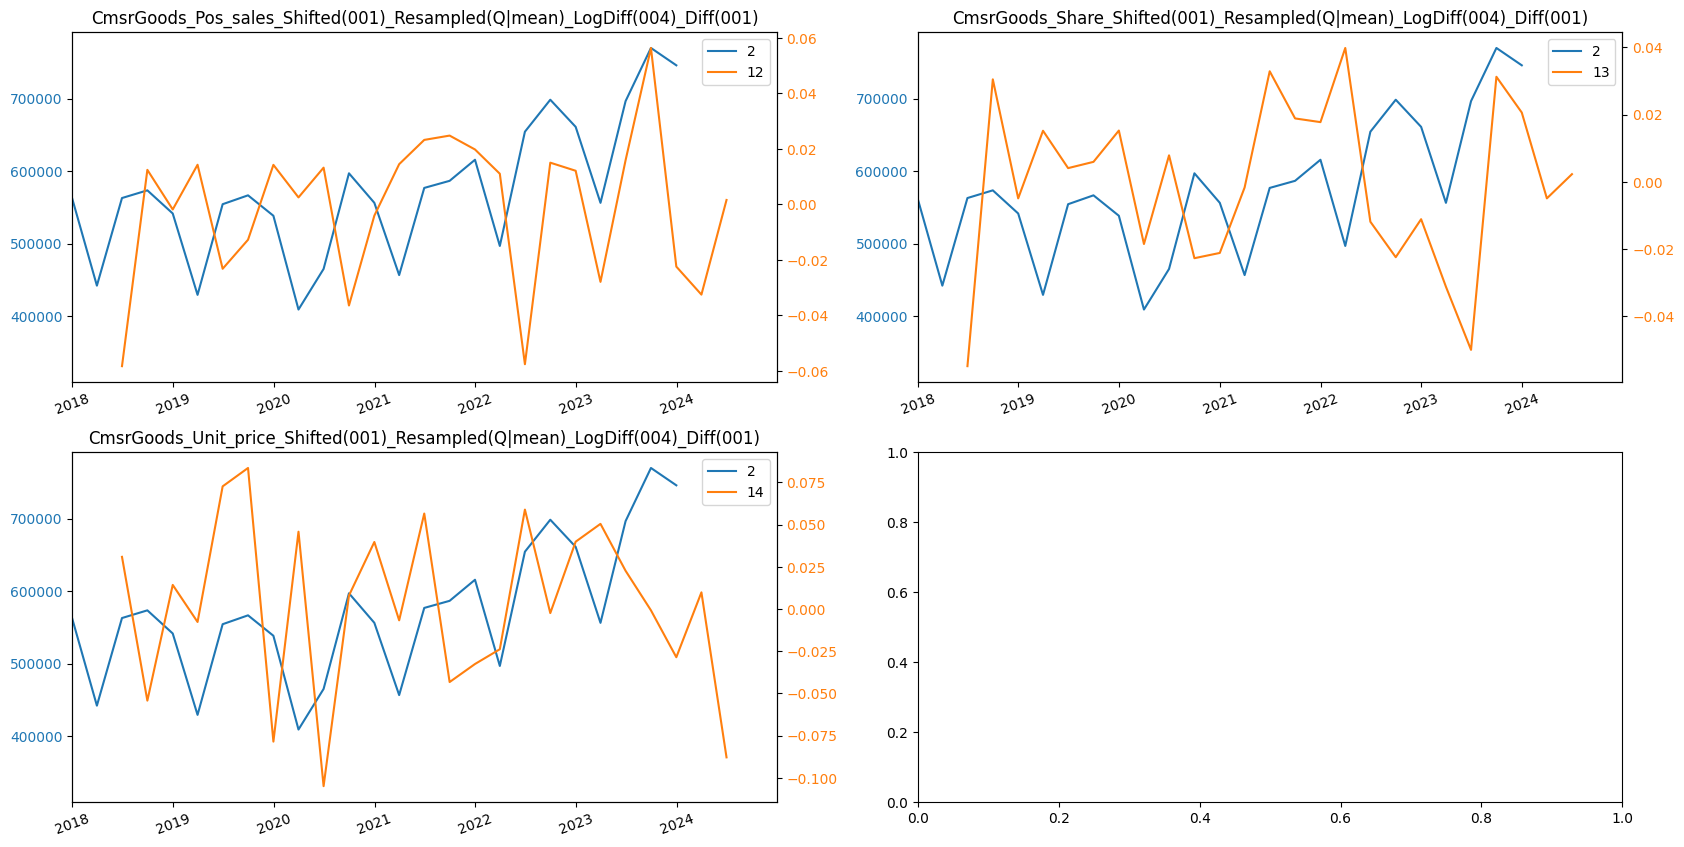

In [30]:
start_date='2018-01-01'

sdh.show_line_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[:4],
    start_date=start_date,
    col_num=2,
    chunk_size=6,
)

ターゲット（ticker）毎にKPI(y)と変数(x)をline描画

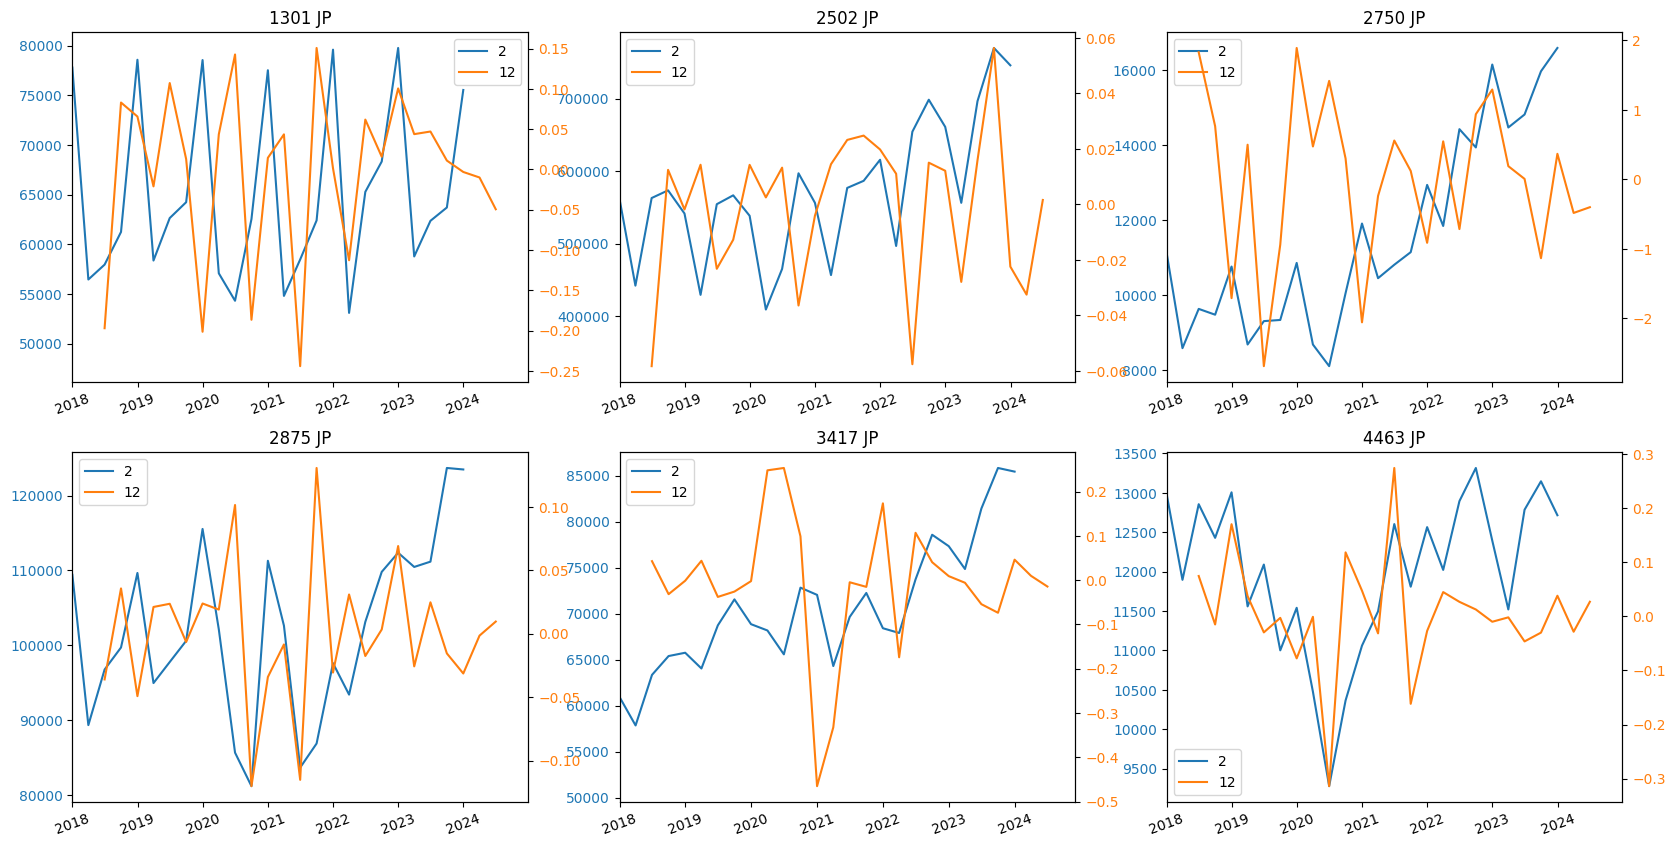

In [31]:
sdh.show_line_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    chunk_size=6)


### Plot Scatter

指定したターゲット(ticker)のKPI(y)と他の変数(X)との散布図を描画

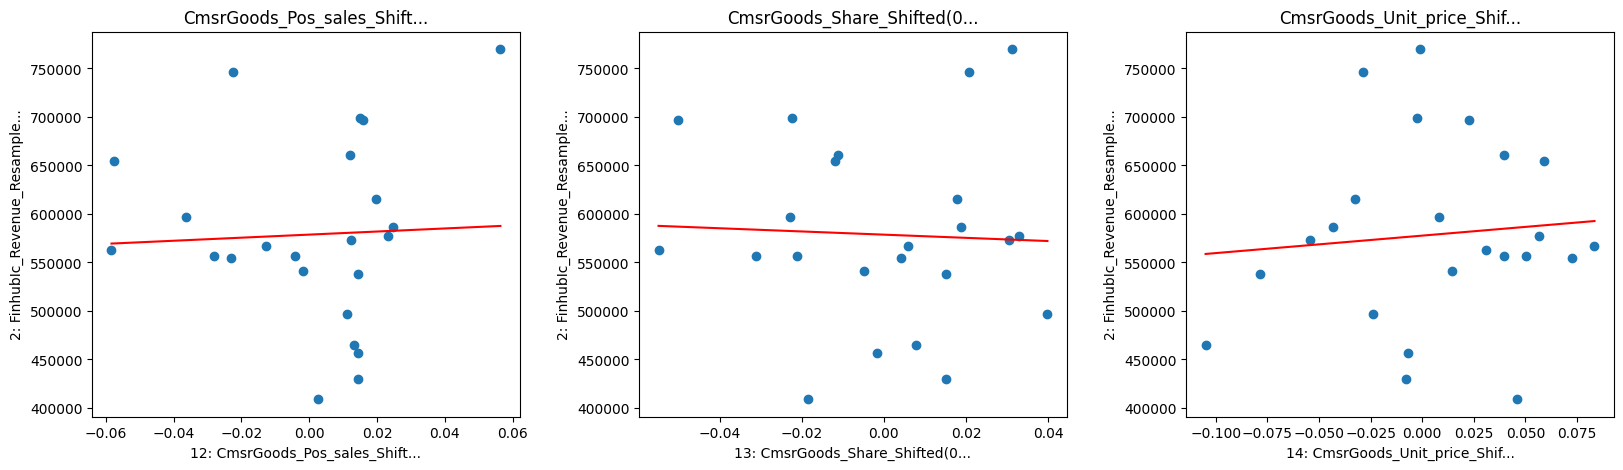

In [32]:
sdh.show_scatter_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[-6:],
    start_date=start_date,
    col_num=3,
    vname_len_limit=25,
)

ターゲット（ticker）毎のKPI(y)と変数(x)の散布図を描画

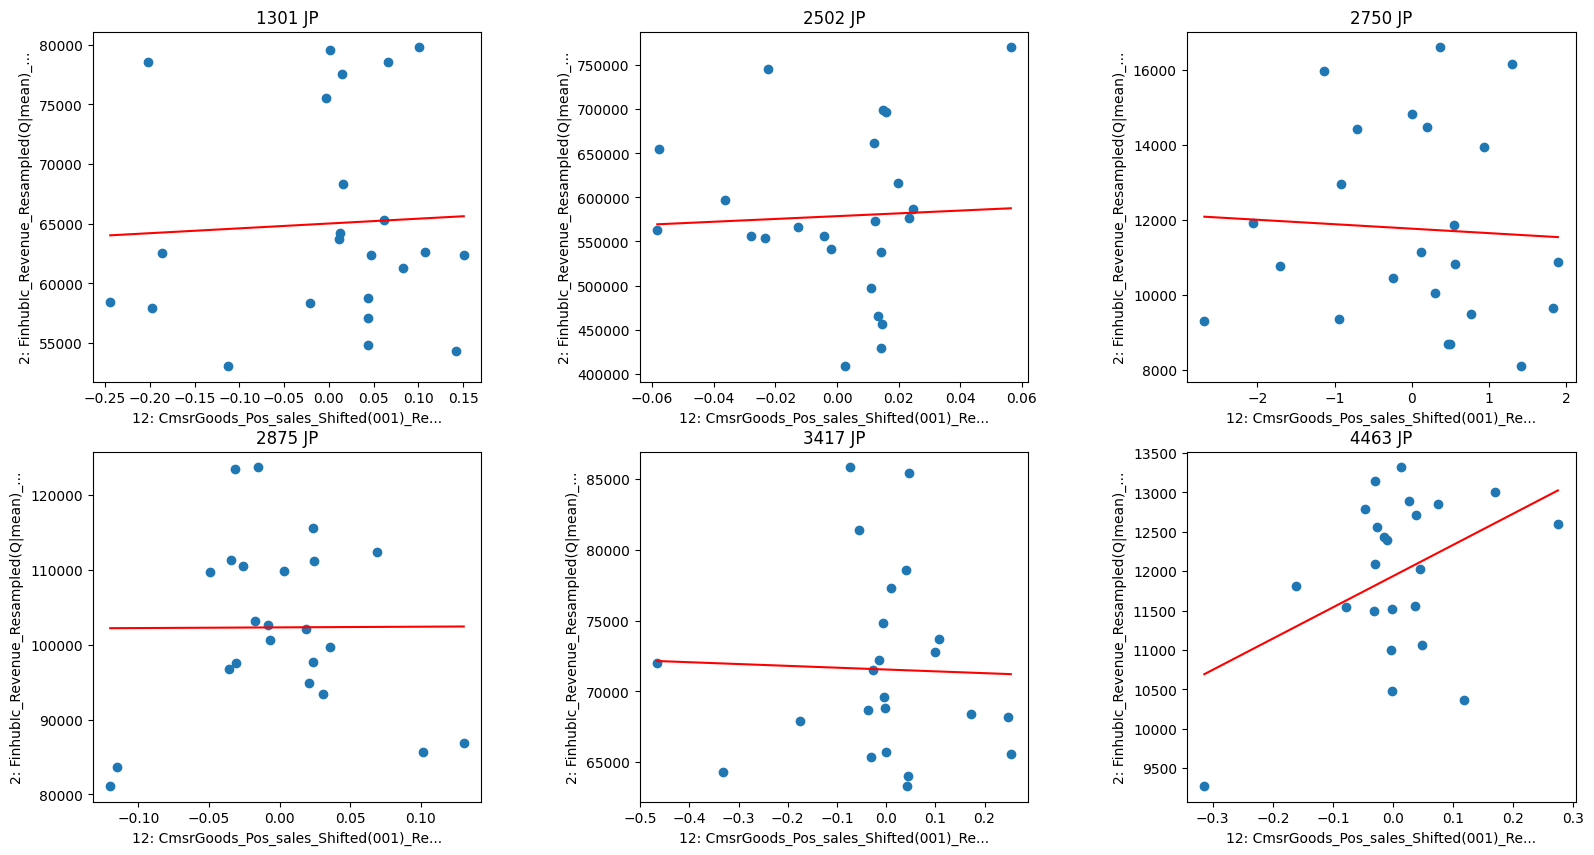

In [33]:
sdh.show_scatter_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    vname_len_limit=35,
)